# packages 

In [41]:
import numpy as np
import pandas as pd
import xarray
import funcs as f

In [68]:
import os

In [108]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
fs=14
plt.rc("font",size=fs)

### parameters

In [75]:
year  = 2015
month = 3

spacings = {"mynn":333, "ysu":333, "sh":333, "vles":333, "LES":25, "LES_raw":25}

In [84]:
colors = { "LES":"k",
          "LES_raw":"k",
          "vles":"#808B96",
          "mynn":"#641E16",
           "ysu":"#A93226",
            "sh":"#D98880",}

In [65]:
varname = "w"
day    = 20
hour   = 14
minute = 0
datetime = pd.Timestamp(year=year,month=month,day=day,hour=hour,minute=minute)
datetime_str = "{0:%Y-%m-%d_%H:%M}".format(datetime)
sims = ["LES","vles","mynn","ysu","sh"]
datapath = "/Volumes/Baby-Orange/XPIA-NCAR/rawest/"

### io

In [66]:
df_zi       = pd.read_csv("/Volumes/Baby-Orange/XPIA-NCAR/processed/ziL_all_days.csv", header=None, index_col=[0], parse_dates=True)
z_zi_target = 0.5

In [151]:
zi = df_zi.loc[datetime].values[0]

arrays = {}
full_arrays = {}

for sim in sims:        
    
    print("................")
    
    sim_prefix = sim+"_25m" if sim=="LES" else sim
    fpath     = os.path.join(datapath,"WRF_{0}_3D_{1}_plus_filtered.nc".format(sim_prefix,datetime_str))
    data      = xarray.open_dataset(fpath)

    z         = all_data['z']
    zmean     = np.median(z.values,axis=(1,2))
    z_zi      = zmean/zi    
    k         = np.argmin(np.abs(z_zi-z_zi_target))    
    
    variable  = data[varname+"_filt"]
    mean      = np.mean(variable.values,axis=(1,2))
    prime     = variable.values - mean[:,np.newaxis,np.newaxis]
    array     = prime[k,...].copy()
    
    print("Simulation : {0}".format(sim))
    print("Vertical level : {0}".format(k)) 

    full_arrays[sim] = variable[k,...].copy()
    arrays[sim] = array.copy()
    
    if sim=="LES":
        variable  = data[varname]
        mean      = np.mean(variable.values,axis=(1,2))
        prime     = variable.values - mean[:,np.newaxis,np.newaxis]
        array     = prime[k,...].copy()    
        arrays[sim+"_raw"] = array.copy()
        full_arrays[sim+"_raw"] = variable[k,...].copy()

................
Simulation : LES
Vertical level : 7
................
Simulation : vles
Vertical level : 7
................
Simulation : mynn
Vertical level : 7
................
Simulation : ysu
Vertical level : 7
................
Simulation : sh
Vertical level : 7


### computations

#### ==> cartesian

In [76]:
f1d    = {}
f2d    = {}
psd_2d = {}

for key in arrays.keys():
    f1d[key], f2d[key], psd_2d[key] = f.get_psd_2d(arrays[key], spacing=spacings[key])

#### ==> polar

In [77]:
x     = {}
y     = {}
theta = {}
r     = {}
psd   = {}

for key in arrays.keys():
    x[key], y[key], theta[key], r[key], psd[key] = f.psd_cartesian_to_polar(f1d[key],psd_2d[key],thetas=np.arange(135,315.1,0.5))

#### => azimuthal means

In [78]:
r1d = {}
p1d = {}

for key in arrays.keys():
    p1d[key]   = np.nanmean(psd[key],1)
    r1d[key]     = np.nanmean(r[key],1)

### figures (optional)

#### ==> flow field contours

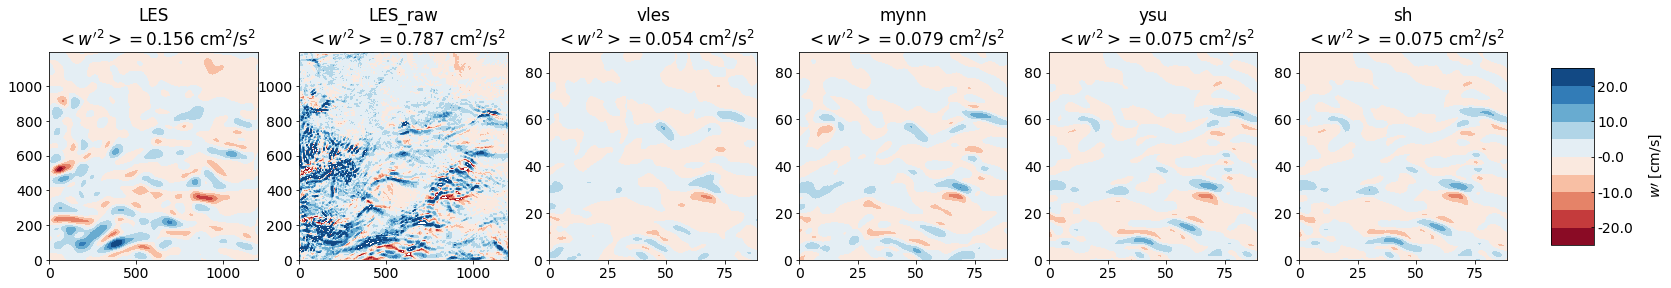

In [157]:
keys_in_order = ["LES_raw","LES","vles","mynn","ysu","sh"]

fig = plt.figure(figsize=(6*5,5))
axs = {}

for iax,sim in enumerate(arrays.keys()):
    axs[iax] = fig.add_subplot(1,6,iax+1,aspect="equal")
    
    p = axs[iax].contourf(arrays[sim]*100, levels=np.arange(-0.25,0.251,0.05)*100, cmap='RdBu')
    variance = np.var(arrays[sim])
    axs[iax].set_title(sim+"\n $<w'^2>={0:.3f}$ cm$^2$/s$^2$".format(variance*100))
    #plt.colorbar(p)
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.255, 0.02, 0.49])
clb = fig.colorbar(p, cax=cbar_ax, format=FormatStrFormatter('%3.1f'))
clb.set_label('$w\prime$ [cm/s]', labelpad=15, y=0.45)
clb.ax.tick_params(direction='in')     

#### ==> cartesian

In [70]:
# fig = f.plot_psd_cartesian(f1d,psd_2d,vmin=-5,vmax=7)
# fig = f.plot_psd_cartesian(f1d_filt,psd_2d_filt,vmin=-5,vmax=7)

#### ==> polar

In [71]:
# fig = f.plot_psd_polar(theta,r,psd,vmin=-4,vmax=7)
# fig = f.plot_psd_polar(thetafilt,rfilt,psdfilt,vmin=-4,vmax=7)

#### ==> azimuthal means

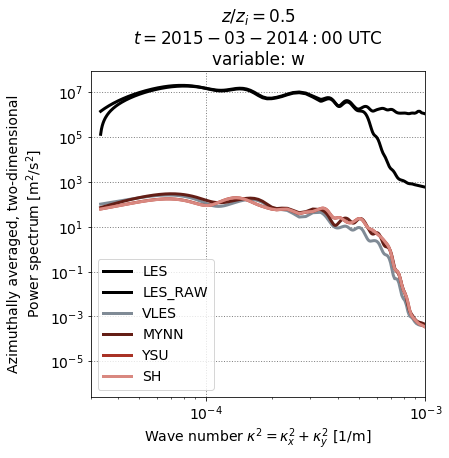

In [93]:
fig = plt.figure(figsize=(6,6))
ax  = fig.add_subplot(111)
ax.grid(color='gray', linestyle=':', linewidth=1)

for key in arrays.keys():
    ax.loglog(r1d[key],p1d[key],lw=3,label=key.upper(),color=colors[key])

ax.set_xlabel("Wave number $\kappa^2=\kappa_x^2+\kappa_y^2$ [1/m]")
ax.set_ylabel("Azimuthally averaged, two-dimensional\nPower spectrum [m$^2$/s$^2$]")
ax.set_xlim([3e-5,1e-3])
ax.set_title("$z/z_i={0}$".format(z_zi_target)+"\n$t={0:%Y-%m-%d %H:%M}$ UTC".format(datetime)+"\nvariable: {0}".format(varname))
plt.legend()

# junkyard

In [129]:
from scipy.integrate import simps

In [138]:
from scipy import fftpack

In [137]:
key="LES_raw"

In [160]:
for key in arrays.keys():
    
    print(".............")
    print(key)
    
    # apply fft
    fftarray  = fftpack.fft2(arrays[key])
    npts,npts = arrays[key].shape
    fr        = fftpack.fftfreq(npts, d=spacings[key])
    var1      = simps(simps(np.abs(fftarray), fr), fr)
    print("{0:.3f} cm2/s2".format(var1*100))


    fftarray_shifted = fftpack.fftshift(fftarray)
    psd_2d           = np.abs(fftarray_shifted)**2
    fr               = np.sort(fr)
    var2             = simps(simps(np.abs(psd_2d), fr), fr)
    print("{0:.3f} cm2/s2".format(var2*100))
    

.............
LES
0.128 cm2/s2
360.307 cm2/s2
.............
LES_raw
-5299.546 cm2/s2
1812.857 cm2/s2
.............
vles
0.000 cm2/s2
0.004 cm2/s2
.............
mynn
0.000 cm2/s2
0.006 cm2/s2
.............
ysu
0.000 cm2/s2
0.006 cm2/s2
.............
sh
0.000 cm2/s2
0.006 cm2/s2


In [136]:
for key in keys_in_order:
    print (key, simps(simps(psd_2d[key], f1d[key]), f1d[key]))

LES_raw 18.505855486800726
LES 4.224238849404005
vles 3.0188613995547425e-05
mynn 4.363883293651493e-05
ysu 4.224404909962288e-05
sh 4.2233218071212604e-05
